# Viet Nam Stock Market Prediction
### Kaggle 02 - TowardDataScience
[Link to the competition](https://www.kaggle.com/c/stock-market-prediction/overview)

--------------------------------

### Task 1: Importing libraries needed to use

**Requirements**

In [1]:
%load_ext watermark
%watermark -a "Nguyen Huu Duc" -p numpy,matplotlib,pandas,sklearn,dirty_cat,tqdm,xgboost

Author: Nguyen Huu Duc

numpy     : 1.21.4
matplotlib: 3.5.1
pandas    : 1.3.5
sklearn   : 1.0.2
dirty_cat : 0.2.0
tqdm      : 4.62.3
xgboost   : 1.5.1



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, TweedieRegressor
from dirty_cat import SimilarityEncoder, TargetEncoder, GapEncoder, SuperVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.ensemble import StackingRegressor, AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor 
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.inspection import permutation_importance
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
%matplotlib inline

### Task 2: Preparing proper form of input data for both traing and testing

In [3]:
# read training data 
df = pd.read_csv('price_train.csv')
df

,date,open,high,low,close,volume,symbol
0,2021-01-04,17.05,17.70,16.90,17.55,46809600,STB
1,2021-01-05,17.55,17.95,17.45,17.70,23399500,STB
2,2021-01-06,17.90,18.35,17.70,18.00,32553600,STB
3,2021-01-07,18.05,18.45,17.85,18.45,40903700,STB
4,2021-01-08,18.80,19.50,18.65,19.40,36089200,STB
...,...,...,...,...,...,...,...
6144,2021-10-25,75.90,76.90,75.50,76.00,315300,REE
6145,2021-10-26,75.30,76.00,73.50,75.20,401500,REE
6146,2021-10-27,74.90,76.30,74.30,76.00,547600,REE
6147,2021-10-28,75.80,76.90,75.50,76.00,424400,REE


In [4]:
# Note: don't use the 'price_test.csv' 
sub = pd.read_csv('sample_submission.csv')
sub

,Id,Predicted
0,2021-11-01:BID,0.0
1,2021-11-02:BID,0.0
2,2021-11-03:BID,0.0
3,2021-11-04:BID,0.0
4,2021-11-05:BID,0.0
...,...,...
625,2021-11-23:VRE,0.0
626,2021-11-24:VRE,0.0
627,2021-11-25:VRE,0.0
628,2021-11-26:VRE,0.0


In [5]:
# create a df_test
data = [i for i in sub['Id'].str.split(':')]

df_test = pd.DataFrame(data, columns=['date', 'symbol'])
df_test

,date,symbol
0,2021-11-01,BID
1,2021-11-02,BID
2,2021-11-03,BID
3,2021-11-04,BID
4,2021-11-05,BID
...,...,...
625,2021-11-23,VRE
626,2021-11-24,VRE
627,2021-11-25,VRE
628,2021-11-26,VRE


### Task 3: Create a custom function transformer for feature engineering with datetime

In [6]:
# define a function to create "month" and "day of year" features
def datetime_features(df):
    df = pd.DataFrame(df)
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month 
    df['day_of_year'] = df['date'].dt.dayofyear
    return df[['month', 'day_of_year']]

In [7]:
# make a custom transformer
make_datetime_features = FunctionTransformer(datetime_features)

In [8]:
# check whether the custom function work or not by trying "fit_transform" method
make_datetime_features.fit_transform(df[['date']])

,month,day_of_year
0,1,4
1,1,5
2,1,6
3,1,7
4,1,8
...,...,...
6144,10,298
6145,10,299
6146,10,300
6147,10,301


### Task 4: Select the best encoder for the model

In [9]:
features = ['date', 'symbol']

X = df[['symbol', 'date']]
y = df['close']

In [10]:
# Prepare a dict of encoders for looping
encoders = {}
encoders['one-hot'] = OneHotEncoder(handle_unknown='ignore')
encoders['similarity'] = SimilarityEncoder(similarity='ngram')
encoders['target'] = TargetEncoder(handle_unknown='ignore')
encoders['gap'] = GapEncoder(n_components=20, random_state=5)
encoders['super-vectorizer'] = SuperVectorizer(auto_cast=True, cardinality_threshold=20)
encoders

{'one-hot': OneHotEncoder(handle_unknown='ignore'),
 'similarity': SimilarityEncoder(),
 'target': TargetEncoder(handle_unknown='ignore'),
 'gap': GapEncoder(n_components=20, random_state=5),
 'super-vectorizer': SuperVectorizer(cardinality_threshold=20)}

In [11]:
# We now loop over the different encoding methods, 
# instantiate a new Pipeline each time, 
# fit it and store the returned cross-validation score.

kf = KFold(5, shuffle=True, random_state=1)

for name, method in tqdm(encoders.items()):
    
    # make a transformer to try out different encoding methods
    ct = make_column_transformer((method, ['symbol']),
                                 (make_datetime_features, ['date']))
    
    # initialize xgboost regression model
    xgb_reg = XGBRegressor(n_estimators=5000, 
                           learning_rate=0.04, 
                           random_state=1, 
                           n_jobs=-1)
    
    # prepare a scaling for the pipeline
    scaler = StandardScaler(with_mean=False)
    
    # make a pipline with the transformer, sclaer, and model respectively
    pipe = make_pipeline(ct, scaler, xgb_reg)
    
    # compute cross-validation score.
    scores = cross_val_score(pipe, X, y, cv=kf, scoring='neg_mean_absolute_percentage_error', n_jobs=-1).mean()
    mape = scores*(-1)
    print(f'{name.title()} Encoding (MAPE={mape:.3f})')

  0%|          | 0/5 [00:00<?, ?it/s]

One-Hot Encoding (MAPE=0.013)
Similarity Encoding (MAPE=0.013)
Target Encoding (MAPE=0.014)
Gap Encoding (MAPE=0.318)
Super-Vectorizer Encoding (MAPE=0.035)


**Choose one-hot encoding as an encoder for the model.**

### Task 5: Compute feature Importance by using permutation importance

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.4, 
                                                    random_state=1)

In [13]:
ohe = OneHotEncoder(handle_unknown='ignore')

ct = make_column_transformer((ohe, ['symbol']),
                             (make_datetime_features, ['date']))

In [14]:
X_train_transformed = ct.fit_transform(X_train).toarray()
X_test_transformered = ct.transform(X_test).toarray()

In [15]:
xgb_reg = XGBRegressor(n_estimators=5000, 
                       learning_rate=0.04, 
                       random_state=1, n_jobs=-1)

xgb_reg.fit(X_train_transformed, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.04, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=5000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=1, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [16]:
result = permutation_importance(estimator=xgb_reg, 
                                X=X_test_transformered, y=y_test, 
                                scoring='neg_mean_absolute_percentage_error', 
                                n_repeats=60,
                                random_state=1,
                                n_jobs=-1)

C:\Users\HP\anaconda3\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [17]:
result.importances_mean

array([0.01270159, 0.00520808, 0.02050573, 0.03260261, 0.03868564,
       0.04414285, 0.0069227 , 0.02152181, 0.03365376, 0.05714756,
       0.0959571 , 0.04524401, 0.02477231, 0.002608  , 0.04005744,
       0.14272968, 0.005013  , 0.06248544, 0.01792793, 0.05037472,
       0.00965443, 0.06997572, 0.02799712, 0.04755115, 0.04137606,
       0.05277803, 0.06280042, 0.04033724, 0.01390998, 0.03666372,
       0.01242441, 0.12002375])

In [18]:
result.importances_std

array([0.00050434, 0.00040862, 0.0008151 , 0.00231209, 0.0023726 ,
       0.00111357, 0.00038238, 0.00069298, 0.00095899, 0.00438355,
       0.00508131, 0.00371595, 0.00205477, 0.00020745, 0.00323329,
       0.00316568, 0.00066508, 0.00157785, 0.00087664, 0.00120239,
       0.00067406, 0.00154681, 0.00082349, 0.00303437, 0.00289125,
       0.00287208, 0.00513757, 0.00232859, 0.00087463, 0.00066885,
       0.00029598, 0.00212804])

In [19]:
feature_names = ct.transformers_[0][1].categories_[0]
feature_names

array(['BID', 'BVH', 'CTG', 'FPT', 'GAS', 'HDB', 'HPG', 'KDH', 'MBB',
       'MSN', 'MWG', 'NVL', 'PDR', 'PLX', 'PNJ', 'POW', 'REE', 'SBT',
       'SSI', 'STB', 'TCB', 'TCH', 'TPB', 'VCB', 'VHM', 'VIC', 'VJC',
       'VNM', 'VPB', 'VRE'], dtype=object)

In [20]:
feature_labels = np.r_[feature_names, ['month', 'day_of_year']]
feature_labels

array(['BID', 'BVH', 'CTG', 'FPT', 'GAS', 'HDB', 'HPG', 'KDH', 'MBB',
       'MSN', 'MWG', 'NVL', 'PDR', 'PLX', 'PNJ', 'POW', 'REE', 'SBT',
       'SSI', 'STB', 'TCB', 'TCH', 'TPB', 'VCB', 'VHM', 'VIC', 'VJC',
       'VNM', 'VPB', 'VRE', 'month', 'day_of_year'], dtype=object)

In [21]:
sorted_indices = result['importances_mean'].argsort()
sorted_indices

array([13, 16,  1,  6, 20, 30,  0, 28, 18,  2,  7, 12, 22,  3,  8, 29,  4,
       14, 27, 24,  5, 11, 23, 19, 25,  9, 17, 26, 21, 10, 31, 15],
      dtype=int64)

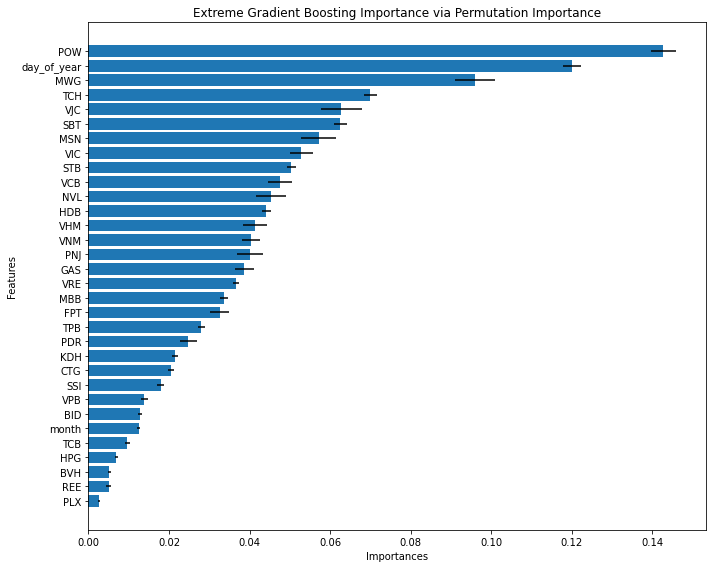

In [22]:
plt.figure(figsize=(10, 8))
plt.title('Extreme Gradient Boosting Importance via Permutation Importance')

plt.barh(
    feature_labels[sorted_indices], 
    result['importances_mean'][sorted_indices],
    xerr=result['importances_std'][sorted_indices]
)

plt.ylabel('Features')
plt.xlabel('Importances')

plt.tight_layout()
plt.show()

### Task 6: Create transformers and pipelines

In [23]:
# transformers
ohe = OneHotEncoder(handle_unknown='ignore')
ct = make_column_transformer((ohe, ['symbol']), 
                             (make_datetime_features, ['date']))



#############################################################################################
################################# initialize model ##########################################

# model 1
xgb_reg = XGBRegressor(n_estimators=5000, 
                       learning_rate=0.04, 
                       random_state=1, n_jobs=-1)

# model 2
tree_1 = DecisionTreeRegressor(max_depth=None, random_state=2)
bag_reg = BaggingRegressor(base_estimator=tree_1, 
                           n_estimators=5000, 
                           random_state=1)

# model 3
forest_reg = RandomForestRegressor(n_estimators=5000, 
                                   random_state=2)

# model 4
linreg = LinearRegression()

# model 5
tweed = TweedieRegressor(power=1, alpha=0.1, link='log')

# model 6
tree_2 = DecisionTreeRegressor(max_depth=None, random_state=2)
ada_boost_reg = AdaBoostRegressor(base_estimator=tree_2, 
                                  learning_rate=0.2,
                                  random_state=1, 
                                  n_estimators=5000)

# model 7
mlp_reg = MLPRegressor(random_state=1, 
                       max_iter=234, 
                       hidden_layer_sizes=(15000,))

# model 8
gradient_boost_reg = GradientBoostingRegressor(random_state=0, 
                                               n_estimators=5000)

# model 9
estimators = [('lr', xgb_reg), 
              ('svr', LinearSVR(random_state=42))]

stacking_reg = StackingRegressor(estimators=estimators, 
                                 final_estimator=RandomForestRegressor(n_estimators=5000,
                                                                       random_state=42))

# model 10
extra_tree = ExtraTreesRegressor(n_estimators=5000, 
                                 random_state=0)

# model 11
hist_boost_reg = HistGradientBoostingRegressor(learning_rate=0.5,
                                               max_iter=1000)


# prepare a scaler for doing scaling after the step of transformation in the pipeline
scaler = StandardScaler(with_mean=False)



#############################################################################################
################################## make pipelines ###########################################

pipe_1 = make_pipeline(ct, scaler, xgb_reg)
pipe_2 = make_pipeline(ct, bag_reg)
pipe_3 = make_pipeline(ct, forest_reg)
pipe_4 = make_pipeline(ct, scaler, linreg)
pipe_5 = make_pipeline(ct, scaler, tweed)
pipe_6 = make_pipeline(ct, ada_boost_reg)
pipe_7 = make_pipeline(ct, scaler, mlp_reg)
pipe_8 = make_pipeline(ct, scaler, gradient_boost_reg)
pipe_9 = make_pipeline(ct, stacking_reg)
pipe_10 = make_pipeline(ct, extra_tree)

### Task 7: fit and make predictions

In [24]:
X_test = df_test[features]

In [25]:
# model 1: xgboost
pipe_1.fit(X, y)
y_pred_1 = pipe_1.predict(X_test)
print('Model 1: Done')

# model 2: bagging
pipe_2.fit(X, y)
y_pred_2 = pipe_2.predict(X_test)
print('Model 2: Done')

# model 3: random forests
pipe_3.fit(X, y)
y_pred_3 = pipe_3.predict(X_test)
print('Model 3: Done')

# model 4: linear regression
pipe_4.fit(X, y)
y_pred_4 = pipe_4.predict(X_test)
print('Model 4: Done')

# model 5: tweed
pipe_5.fit(X, y)
y_pred_5 = pipe_5.predict(X_test)
print('Model 5: Done')

# model 6: adaboost
pipe_6.fit(X, y)
y_pred_6 = pipe_6.predict(X_test)
print('Model 6: Done')

# model 7: mlp
pipe_7.fit(X, y)
y_pred_7 = pipe_7.predict(X_test)
print('Model 7: Done')

# model 8: gradient boosting 
pipe_8.fit(X, y)
y_pred_8 = pipe_8.predict(X_test)
print('Model 8: Done')

# model 9: stacking 
pipe_9.fit(X, y)
y_pred_9 = pipe_9.predict(X_test)
print('Model 9: Done')

# model 10: extra tree
pipe_10.fit(X, y)
y_pred_10 = pipe_10.predict(X_test)
print('Model 10: Done')

# model 11: hist
X = ct.fit_transform(X).toarray()
X_test = ct.transform(X_test).toarray()

hist_boost_reg.fit(X, y)
y_pred_11 = hist_boost_reg.predict(X_test)
print('Model 11: Done')

C:\Users\HP\anaconda3\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


Model 1: Done
Model 2: Done
Model 3: Done
Model 4: Done
Model 5: Done
Model 6: Done
Model 7: Done
Model 8: Done


C:\Users\HP\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA

Model 9: Done
Model 10: Done
Model 11: Done


In [26]:
pipe_11 = make_pipeline(ct, scaler, extra_tree)

### Task 8: Make a weighted average ensemble

In [27]:
# manually ensembling
y_pred = (5*y_pred_1 + 2*y_pred_2 + 2*y_pred_3 + 
          y_pred_4 + y_pred_5 + 2*y_pred_6 + 
          y_pred_7 + 3*y_pred_8 + y_pred_9 + 
          3*y_pred_10 + 7*y_pred_11) / 28
y_pred

array([ 41.38493247,  41.38805961,  41.39095435,  41.39416447,
        41.39725886,  41.40728786,  41.41152155,  41.41775758,
        41.42132998,  41.42610928,  41.43719692,  41.44108019,
        41.44493397,  41.44877364,  41.45119329,  41.46281758,
        41.46665031,  41.47031208,  41.47447579,  41.47963414,
        41.49136799,  63.80873182,  63.81275362,  63.81716507,
        63.8259321 ,  63.83036003,  63.84508623,  63.84959616,
        63.85405283,  63.86596809,  63.87043664,  63.88495121,
        63.89099204,  63.89548334,  63.91198285,  63.91642901,
        63.9299536 ,  63.93446756,  63.93898498,  63.945291  ,
        63.95010919,  63.9749466 ,  32.39626336,  32.39914272,
        32.40208426,  32.40651944,  32.41009642,  32.41917346,
        32.42208218,  32.42531251,  32.42832852,  32.43140752,
        32.44102819,  32.44434902,  32.44769171,  32.45107931,
        32.45450577,  32.46647738,  32.46995651,  32.47377427,
        32.47605745,  32.47432526,  32.46188005,  95.01

### Task 9: Make a submission

In [28]:
sub

,Id,Predicted
0,2021-11-01:BID,0.0
1,2021-11-02:BID,0.0
2,2021-11-03:BID,0.0
3,2021-11-04:BID,0.0
4,2021-11-05:BID,0.0
...,...,...
625,2021-11-23:VRE,0.0
626,2021-11-24:VRE,0.0
627,2021-11-25:VRE,0.0
628,2021-11-26:VRE,0.0


In [29]:
# substitute fake values to predictions
sub['Predicted'] = y_pred
sub

,Id,Predicted
0,2021-11-01:BID,41.384932
1,2021-11-02:BID,41.388060
2,2021-11-03:BID,41.390954
3,2021-11-04:BID,41.394164
4,2021-11-05:BID,41.397259
...,...,...
625,2021-11-23:VRE,31.631350
626,2021-11-24:VRE,31.642085
627,2021-11-25:VRE,31.649015
628,2021-11-26:VRE,31.654097


In [30]:
# make a submission 
# with adjusted ensembling weights (Public: 4.25316, Private: 4.58788)
sub.to_csv('my_sub.csv', index=False)